# Adding f''

Wavelength was deemed a less importante feature, and as such was replaced by **f''**, a more relevant and perhaps useful feature. The data logs showed a table with various wavelengths corresponding to given f''.

0.7749    2.5787
0.8266    2.8647
0.8856    3.2005
0.9050    3.3128
0.9158    3.3758
Name: F'', dtype: float64 
Size: 33


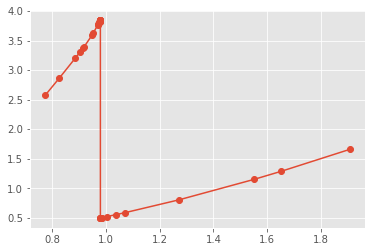

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from scipy.optimize import curve_fit

a = pd.Series({0.7749:2.5787, 0.8266:2.8647, 0.8856:3.2005, 0.9050:3.3128, 0.9158:3.3758, 0.9184:3.3910,
     0.9483:3.5910, 0.9537:3.6339, 0.9700:3.7652, 0.9724:3.7851, 0.9759:3.8143, 0.9762:3.8168, 0.9778:3.8302,
     0.9787:3.8378, 0.9789:3.8395, 0.9790:3.8404, 0.9791:3.8412, 0.9792:3.8421, 0.9793:3.8429, 0.9794:3.8438,
     0.9795:0.4992, 0.9796:0.4993, 0.9798:0.4995, 0.9801:0.4997, 0.9824:0.5019, 0.9840:0.5034, 1.0032:0.5216,
     1.0359:0.5532, 1.0721:0.5891, 1.2716:0.8048, 1.5498:1.1494, 1.6531:1.2890, 1.9075:1.6591}, name="F''")

print(a.head(), f"\nSize: {a.size}")

plt.style.use("ggplot")
plt.plot(a, marker="o")
plt.show()

The data contained a wavelength-to-f'' mapping of 33 discrete wavelengths (0.7749 to 1.9075), however in the whole database there were more than 60 unique wavelengths (0.7514 to 1.5418). As such, a 1-to-1 mapping is not possible for every datapoint.

A possible workaround would be diving the data into low/high f'' ranges (separation at wavelength ~.97) and obtaining a good wavelength-to-f'' model based on the available data, which would then be extended to the range of the entire database. From looking at the image above, a **linear models** and two **power models** (a^x and x^a) were chosen.

LOW:
P1 (a^x): [0.00037954 0.0032495  0.00804007] -> 3.18792190104706e-05
P2 (x^a): [8.03417765e-06 7.96161584e-06 5.04171776e-06] -> 5.97673822418092e-06
HIGH:
P1 (a^x): [4.94035032e+00 3.35335852e-02 3.12174887e-03] -> 0.0011327529315340347
P2 (x^a): [0.02390824 0.01390056 0.00070625] -> 0.0012260790089559503



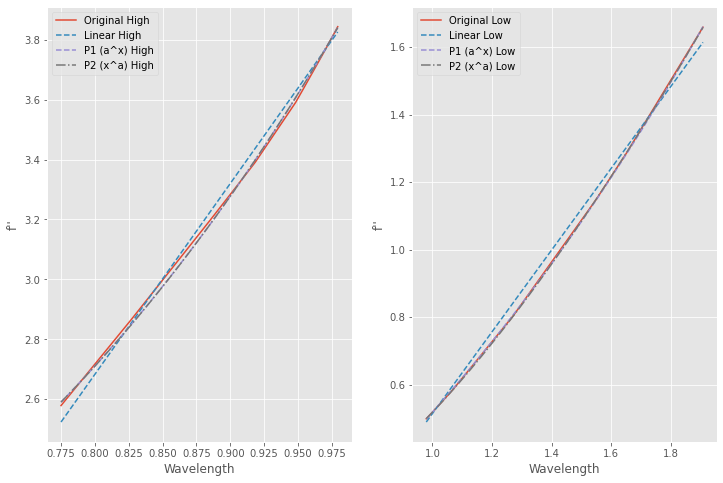

In [2]:
a_df = pd.DataFrame(a)
a_high, a_low = a_df[a > 2.5], a_df[a < 2]

# fit linear model
model_low, model_high = [LinearRegression(), LinearRegression()]
model_low.fit(a_low.index.values.reshape((-1, 1)), a_low.values)
model_high.fit(a_high.index.values.reshape((-1, 1)), a_high.values)

# fit to range
x_low = np.linspace(a_low.index.min(), a_low.index.max()).reshape((-1, 1))
x_high = np.linspace(a_high.index.min(), a_high.index.max()).reshape((-1, 1))
linear_low = model_low.predict(x_low)
linear_high = model_high.predict(x_high)


# fit power models
def power1(x, a, b, c):
     return a ** (x - c) + b

def power2(x, a, b, c):
     return (x - c) ** a + b


p1l_params, p1l_err = curve_fit(power1, a_low.index.values, a_low.values.flatten())
p1_low = power1(x_low, *p1l_params)
p1h_params, p1h_err = curve_fit(power1, a_high.index.values, a_high.values.flatten())
p1_high = power1(x_high, *p1h_params)

p2l_params, p2l_err = curve_fit(power2, a_low.index.values, a_low.values.flatten(), bounds=([.1, -10, -10], [10, 10, 10]))
p2_low = power2(x_low, *p2l_params)
p2h_params, p2h_err = curve_fit(power2, a_high.index.values, a_high.values.flatten(), bounds=([.1, -10, -10], [10, 10, 10]))
p2_high = power2(x_high, *p2h_params)

#plot
plt.style.use("ggplot")
fig, (ax_high, ax_low) = plt.subplots(1, 2, figsize=(12,8))

ax_high.plot(a_high.index, a_high, label="Original High")
ax_low.plot(a_low.index, a_low, label="Original Low")

ax_low.plot(x_low, linear_low, linestyle="dashed", label="Linear Low")
ax_high.plot(x_high, linear_high, linestyle="dashed", label="Linear High")

ax_low.plot(x_low, p1_low, linestyle="dashed", label="P1 (a^x) Low")
ax_high.plot(x_high, p1_high, linestyle="dashed", label="P1 (a^x) High")

ax_low.plot(x_low, p2_low, linestyle="dashdot", label="P2 (x^a) Low")
ax_high.plot(x_high, p2_high, linestyle="dashdot", label="P2 (x^a) High")

ax_low.set_xlabel("Wavelength")
ax_low.set_ylabel("f''")
ax_low.legend()
ax_high.set_xlabel("Wavelength")
ax_high.set_ylabel("f''")
ax_high.legend()

# sum of square residuals
p1l_ssr = np.sum((power1(a_low.index.values, *p1l_params) - a_low.values.flatten()) ** 2)
p1h_ssr = np.sum((power1(a_high.index.values, *p1h_params) - a_high.values.flatten()) ** 2)
p2l_ssr = np.sum((power2(a_low.index.values, *p2l_params) - a_low.values.flatten()) ** 2)
p2h_ssr = np.sum((power2(a_high.index.values, *p2h_params) - a_high.values.flatten()) ** 2)

print(f"LOW:\n"
      f"P1 (a^x): {np.diag(p1l_err)} -> {p1l_ssr}\n"
      f"P2 (x^a): {np.diag(p2l_err)} -> {p2l_ssr}\n"
      f"HIGH:\n"
      f"P1 (a^x): {np.diag(p1h_err)} -> {p1h_ssr}\n"
      f"P2 (x^a): {np.diag(p2h_err)} -> {p2h_ssr}\n")

''' Equal performance '''

plt.show()


The power models are clearly better than the linear one, but there is little to no difference between x^a and a^x models. A sum of the squared residuals is shown before the plots, and from both models can be said to be roughly equally performing.

In this case, the ***(x-c)^a+b* model (2) is chosen**, with optimal parameters:

- *HIGH* (wavelength >= 0.9795):
    - *a = 1.37919369*
    - *b = 0.2780599*
    - *c = 0.64429346*
- *LOW* (wavelength < 0.9795): 
    - *a = 3.92791177*
    - *b = 1.34277082*
    - *c = 0.28303464*

The *LOW* (due to the lower energy and f'') version is for larger wavelengths, and vice versa for the *HIGH* version.

A final model can then be created:

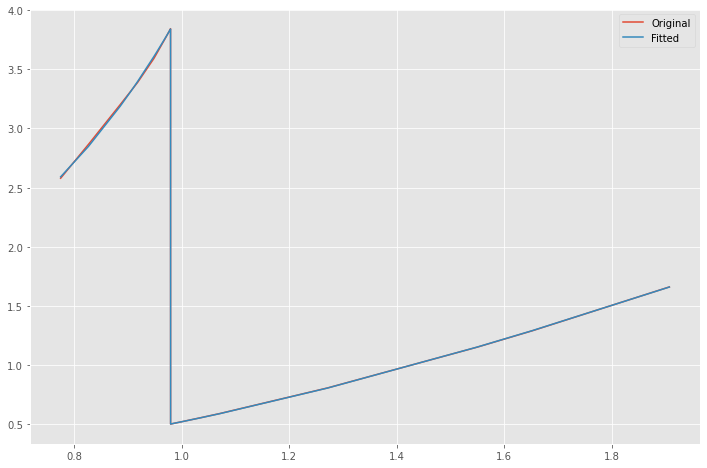

In [3]:
def FDoublePrime(wavelength, threshold=0.9795):
    mask_low = wavelength >= threshold
    mask_high = wavelength < threshold
    result = wavelength.copy()

    a_low, b_low, c_low = 1.37919369, 0.2780599, 0.64429346
    a_high, b_high, c_high = 3.92791177, 1.34277082, -0.28303464

    result[mask_low] = (result[mask_low] - c_low) ** a_low + b_low
    result[mask_high] = (result[mask_high] - c_high) ** a_high + b_high

    return result


fig, ax = plt.subplots(figsize=(12, 8))
ax.plot(a.index, a, label="Original")
ax.plot(a.index.values, FDoublePrime(a.index.values), label="Fitted")
ax.legend()
plt.show()

The previous correlation and mean relative difference by success analysis was repeated, so that the importance of **f''** could be reviewed.

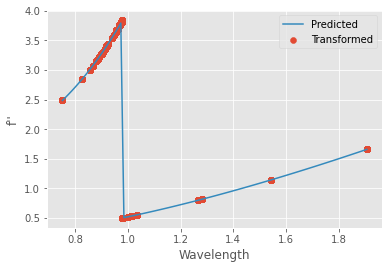

In [7]:
import sqlite3

def sql_to_df(db_file, *tb_names, search_query=None):
    '''
    function to connect to database and convert datum to pandas DataFrame
    use #TB_NAME# to refer to table name
    '''
    # make connection
    conn = sqlite3.connect(db_file)
    cur = conn.cursor()

    for tb_name in tb_names:
        # query table
        cur.execute(search_query.replace("#TB_NAME#", tb_name))
        result = cur.fetchall()

        # fetch column names
        cur.execute(rf"PRAGMA table_info({tb_name})")
        cols = [info[1] for info in cur.fetchall()]

        # create DataFrame
        df = pd.DataFrame(result, columns=cols)
        df.set_index("id", inplace=True)
        df.name = tb_name

        yield df


db_path = r"D:\Diamond\cesar_project.db"
tables = [r"SWEEP_STATS", r"EP_STATS"]  # , r"PDB_DATA", r"DATASET_INFO"]
query = r"SELECT * FROM #TB_NAME#"

sweep_full, ep_full = [i for i in sql_to_df(db_path, *tables, search_query=query)]  # old x, y

# cut to subset
sample_frac = 1
sweep, ep = sweep_full,ep_full#.sample(frac=sample_frac), ep_full.sample(frac=sample_frac)

x = sweep
# define label
y = ep["IS_SUCCESS"]
y.index = ep["DATASET_id"]
y = x["DATASET_id"].map(y)
y.name = "IS_SUCCESS"

# add ep stats to x
mapped = []
for col_name in ["SOLVENT_CONTENT", "NUMBER_SITES"]:
    ep_temp = ep.loc[:, col_name]
    ep_temp.index = ep["DATASET_id"]
    ep_temp = x["DATASET_id"].map(ep_temp)
    ep_temp.name = col_name

    mapped.append(ep_temp)
x = pd.concat([x] + mapped, axis=1)

# analyse f''
dummy_x = np.linspace(x["WAVELENGTH"].min(), x["WAVELENGTH"].max(), 100)
plt.style.use("ggplot")
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

plt.plot(dummy_x, FDoublePrime(dummy_x), c=colors[1], label="Predicted")
plt.scatter(x["WAVELENGTH"], FDoublePrime(x["WAVELENGTH"].values), label="Transformed")

plt.xlabel("Wavelength")
plt.ylabel("f''")
plt.legend()
plt.show()

# replace wavelength by f''
x["WAVELENGTH"] = FDoublePrime(x["WAVELENGTH"].values)
x.rename(columns={"WAVELENGTH": "F''"}, inplace=True)

# limit to common datasets
valid_ids = set.intersection(set(x["DATASET_id"]), set(ep["DATASET_id"]))
a = x["DATASET_id"].isin(valid_ids)
x = x[x["DATASET_id"].isin(valid_ids)]
y = y[y.index.map(sweep["DATASET_id"]).isin(valid_ids)]

# filter out undetermined values
mask = y.isin([1, 0])
y = y[mask]
x = x[mask]
x.drop(columns="WAVE_NAME", inplace=True)


# analyse features
union = pd.concat([x.iloc[:, 1:], y], axis=1)

Since the wavelengths are largely located on discrete values, with a few outliers, the f'' values are the same - mostly localised with little variance and a few outliers (with the exception of the "jump").

In [11]:
from sklearn.preprocessing import StandardScaler

# scale data
x_new = x_new = x.drop("SPACEGROUP", axis=1)  # incompatible with scaler
x_new = pd.DataFrame(StandardScaler().fit_transform(x_new),
                     columns=x_new.columns, index=x_new.index)
x_new["SPACEGROUP"] = x["SPACEGROUP"]

# correlation
corr_sorted = abs(x_new.corrwith(y)).sort_values(ascending=False)
print(corr_sorted)

# grouping by success
grp_both = union.groupby("IS_SUCCESS").agg(["mean", "median"])
rel_diff_both = abs((grp_both.iloc[1, :] - grp_both.iloc[0, :]) / np.mean(grp_both, axis=0))
rel_diff_both = rel_diff_both.sort_values(ascending=False)
print(rel_diff_both * 100)
print(rel_diff_both["F''"] * 100)

HIGH_RES_LIMIT               0.388109
SHELXC_RESOLUTION            0.219051
DIFF_F                       0.180352
SHELXC_CFOM                  0.173497
SHELXC_MULTIPLICITY          0.165726
SHELXC_I_SIGMA               0.165083
I_SIGMA                      0.154476
TOTAL_UNIQUE_OBSERVATIONS    0.143695
ANOMALOUS_CORRELATION        0.143211
RMERGE_I                     0.137550
SHELXC_N_DATA                0.130983
TOTAL_OBSERVATIONS           0.130078
RMEAS_I                      0.129897
RMERGE_DIFF_I                0.100591
RMEAS_DIFF_I                 0.099898
RPIM_I                       0.097748
SHELXC_COMPLETENESS          0.095788
ANOMALOUS_COMPLETENESS       0.093413
RPIM_DIFF_I                  0.093313
DIFF_I                       0.090879
COMPLETENESS                 0.086270
SHELXC_SIGNAL                0.052102
CC_HALF                      0.045610
SHELXC_RANOM                 0.045047
SHELXC_RPIM                  0.045039
NUMBER_SITES                 0.033344
SOLVENT_CONT

Sadly, **f''** seems to be **largely uncorrelated and irrelevant to success** when compared to the other features.

PCA can also be attempted to see the feature's importance acording to it.

[pca] >Processing dataframe..
[pca] >Normalizing input data per feature (zero mean and unit variance)..
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [33] columns of the input data.
[pca] >Fitting using PCA..
[pca] >Computing loadings and PCs..
[pca] >Computing explained variance..
[pca] >Number of components is [17] that covers the [95.00%] explained variance.
[pca] >Outlier detection using Hotelling T2 test with alpha=[0.05] and n_components=[17]
[pca] >Outlier detection using SPE/DmodX with n_std=[2]
      PC                    feature   loading  type
0    PC1                RPIM_DIFF_I  0.290690  best
1    PC2                     DIFF_I  0.367052  best
2    PC3               COMPLETENESS -0.309894  best
3    PC4     ANOMALOUS_MULTIPLICITY  0.370283  best
4    PC5         TOTAL_OBSERVATIONS  0.338103  best
5    PC6               SHELXC_RANOM  0.548811  best
6    PC7          SHELXC_RESOLUTION  0.481150  best
7    PC8            SOLVENT_CONTENT

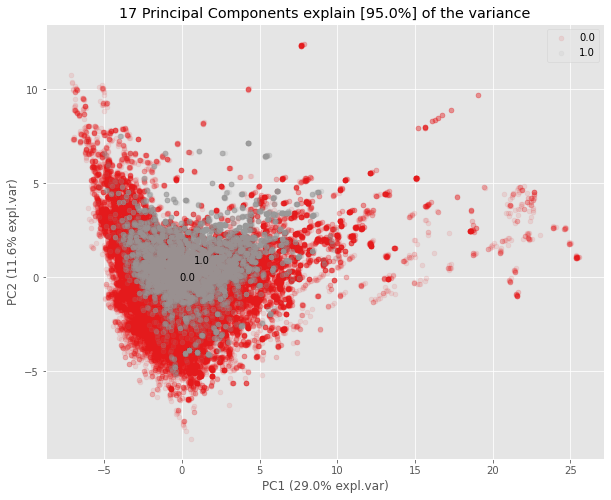

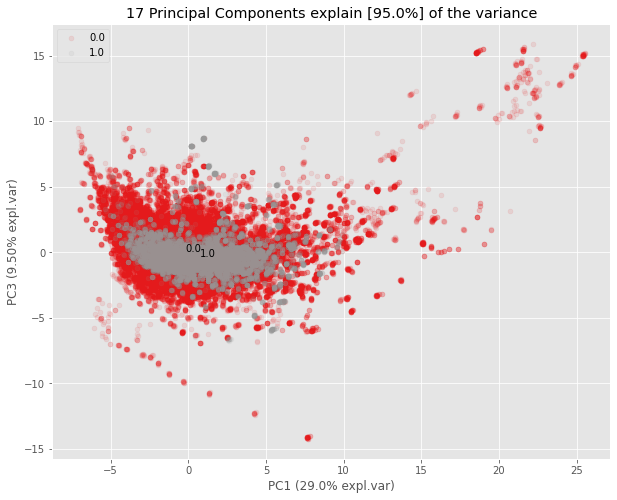

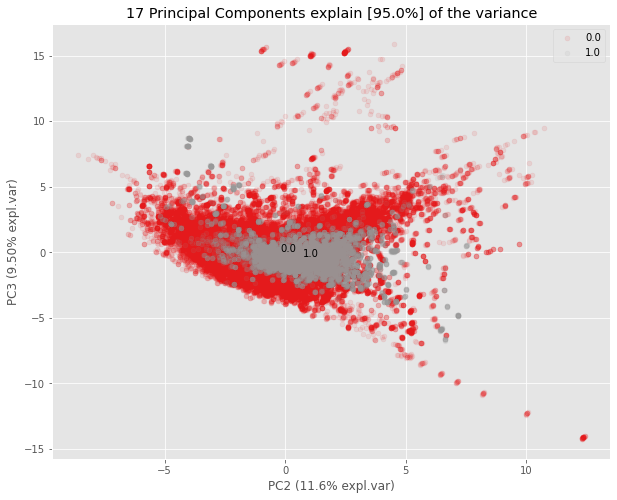

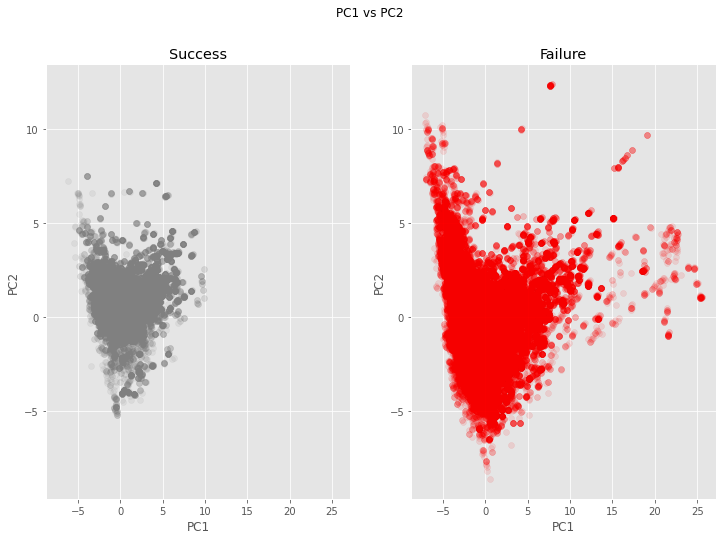

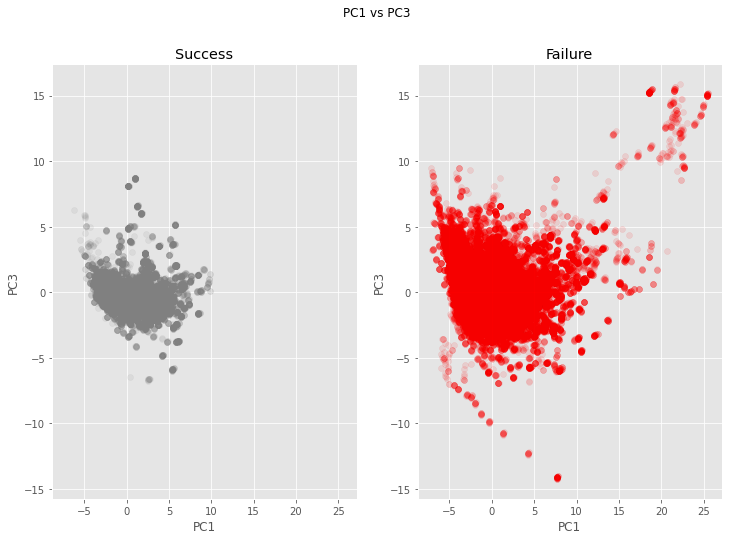

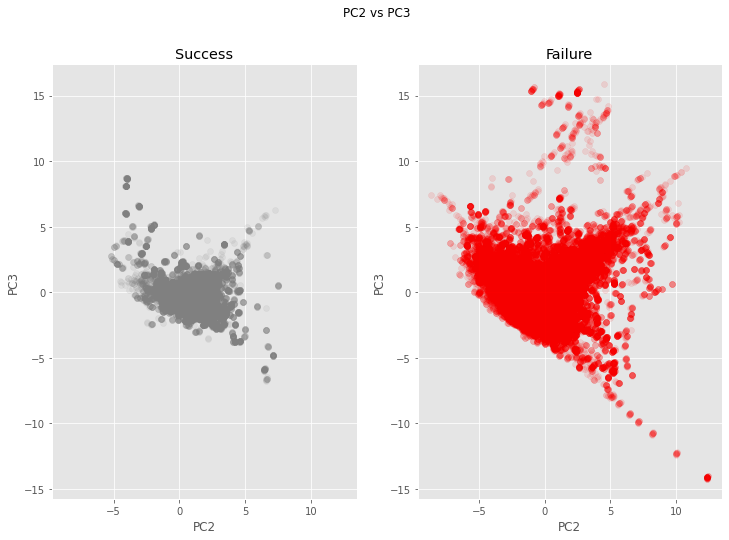

In [14]:
from itertools import combinations
from pca import pca

# print(x, y, sep="\n")
x_new = x.drop("SPACEGROUP", axis=1)  # str column incompatible with pca module

model = pca(n_components=0.95, normalize=True)

# print(x_new, x_new.agg(["mean", "std"]), sep="\n")
results = model.fit_transform(x_new)

print(results['topfeat'], sep="\n")

fig1, ax1 = model.scatter(y=y, PC=[0, 1], alpha_transparency=0.1)
fig2, ax2 = model.scatter(y=y, PC=[0, 2], alpha_transparency=0.1)
fig3, ax3 = model.scatter(y=y, PC=[1, 2], alpha_transparency=0.1)
axs = [ax1, ax2, ax3]

pc = results["PC"].loc[:, :"PC3"]
success = y == 1
pc_success = pc[success]
fail = y == 0
pc_fail = pc[fail]

for i, (h, v) in enumerate(combinations(pc, 2)):
    fig, ax = plt.subplots(1, 2, figsize=(12, 8))
    fig.suptitle(f"{h} vs {v}")

    for j, (data, title, c) in enumerate(zip([pc_success, pc_fail], ["Success", "Failure"], ["grey", "red"])):

        ax[j].scatter(data.loc[:, h], data.loc[:, v], c=c, alpha=.1)

        ax[j].set_xlabel(h)
        ax[j].set_ylabel(v)
        ax[j].set_title(title)

        ax[j].set_xlim(*axs[i].get_xlim())
        ax[j].set_ylim(*axs[i].get_ylim())

plt.show()

Again, PCA says **f'' is one of the (5th) least important feature**.

As such, for now, this will not be considered an essential feature.